In [2]:
import xarray as xr
import datetime
import numpy as np
import matplotlib.pyplot as plt
import eurec4a

from functools import reduce
from scipy.integrate import cumtrapz, trapz
import pandas as pd
from IPython.display import display, Markdown, Math

import warnings
warnings.filterwarnings("ignore")

Some useful functions:

In [3]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

In [4]:
cat = eurec4a.get_intake_catalog(use_ipfs=False)

Pick one EUREC4A flight day (e.g. 22.1, 24.1, 28.1, 2.2, 5.2, 9.2, 15.2 are all interesting days) and compare
the vertical thermodynamic and dynamic structures of three consecutive single dropsondes (e.g. from the
Northernmost or Southernmost dropsonde location) with the structures of the associated circle means.
How does the variability and temporal evolution at the different scales compare

# Load HALO flight phase information

In [5]:
meta = eurec4a.get_flight_segments()

segments = [{**s,
             "platform_id": platform_id,
             "flight_id": flight_id
            }
            for platform_id, flights in meta.items()
            for flight_id, flight in flights.items()
            for s in flight["segments"]
           ]

segments_by_segment_id = {s["segment_id"]: s for s in segments}
segments_ordered_by_start_time = list(sorted(segments, key=lambda s: s["start"]))

circles = [s["segment_id"]
                 for s in segments_ordered_by_start_time
                 if "circle" in s["kinds"]
                 and s["platform_id"] == "HALO"
                ]

circle_start_times = [s["start"]
                 for s in segments_ordered_by_start_time
                 if "circle" in s["kinds"]
                 and s["platform_id"] == "HALO"
                ]
circle_end_times = [s["end"]
                 for s in segments_ordered_by_start_time
                 if "circle" in s["kinds"]
                 and s["platform_id"] == "HALO"
                ]

circle_start_times = np.array(circle_start_times)
circle_end_times = np.array(circle_end_times)
circles = np.array(circles)

# JOANNE Level 4 data

In [6]:
ds_l4 = cat.dropsondes.JOANNE.level4.to_dask()

Use the JOANNE Level 4 dropsonde data to extract some of the most important cloud controlling factors (CCF):
    
- surface wind speed
- wind shear between 0.5 km and 2.5 km
- mesoscale vertical velocity at 1 km, 3 km and 5 km height
- free-tropospheric humidity (700hPa)
- integrated water vapor (vertically integrated specific humidity from the surface up to 7 km.
- lower-tropospheric stability (700hPa − 1000hPa)
- zonal temperature advection (multiply the zonal gradient of temperature, ’dtadx’, with the wind speed, e.g. using the 150 m-level

In [91]:
wind_surf_all = np.full(len(circle_start_times), np.nan)
wind_shear_all = np.full(len(circle_start_times), np.nan)
W_1km_all = np.full(len(circle_start_times), np.nan)
W_3km_all = np.full(len(circle_start_times), np.nan)
W_5km_all = np.full(len(circle_start_times), np.nan)
q_700hPa_all = np.full(len(circle_start_times), np.nan)
IWV_all = np.full(len(circle_start_times), np.nan)
low_trop_s_all = np.full(len(circle_start_times), np.nan)
temp_adv_all = np.full(len(circle_start_times), np.nan)


# Loop through all the circles
for i, circ in enumerate(circles):
    
    ds = ds_l4.isel(circle=i)

    # Surface wind speed (at 10m)
    wind = np.sqrt(ds.u**2 + ds.v**2)
    wind_surf = wind.sel(alt=10)
    wind_surf_all[i] = wind_surf
    
    # Wind shear, wind speed difference, in the trades winds are mostly zonal
    wind_500m = wind.sel(alt=500, method='nearest')
    wind_2500m = wind.sel(alt=2500, method='nearest')
    wind_shear = (wind_2500m - wind_500m).values
    wind_shear_all[i] = wind_shear

    # Mesoscale vertical velocity at 1 km, 3 km, and 5 km
    W_1km = ds.W.sel(alt=1000).values
    W_3km = ds.W.sel(alt=3000).values
    W_5km = ds.W.sel(alt=5000).values
    
    W_1km_all[i] = W_1km
    W_3km_all[i] = W_3km
    W_5km_all[i] = W_5km

    # Free tropospheric humidity
    p_interp = ds.p.interpolate_na(dim='alt',fill_value="extrapolate")
    idx_700hpa, p_700hpa = find_nearest(p_interp, 70000)
    q_700hPa = ds.q[idx_700hpa].values
    q_700hPa_all[i] = q_700hPa
    
    # Density
    rho = p_interp/(287.1 * ds.ta *(1+0.61*ds.q))
    
    # Integrated water vapor (linearly interpolate above 10 m before integrating)
    integrand = ds.q*rho.sel(alt=slice(10, None))
    integrand = integrand.interpolate_na(dim='alt', fill_value='extrapolate').sel(alt=slice(0,7000))
    IWV = trapz(y=integrand.values, x=integrand.alt.values)
    IWV_all[i] = IWV

    # Lower tropospheric stability    
    k = 0.286
    p0 = 101300
    theta = ds.ta * (p0/ds.p)**k
    idx_1000hpa, p_1000hpa = find_nearest(p_interp, 100000)
    low_trop_s = (theta[idx_700hpa] - theta[idx_1000hpa]).values    
    low_trop_s_all[i] = low_trop_s

    # Zonal temperature advection
    temp_adv = ds.dtadx.sel(alt=150).values * (np.sqrt(ds.u.sel(alt=150)**2 + ds.v.sel(alt=150)**2))
    temp_adv_all[i] = temp_adv

# WALES Data

Loop through each day in WALES data and slice the segments corresponding to the circle flight times from the JOANNE Level_4 data. Then average the lidar data between the start/end of each circle to obtain circle averages from WALES data.

Functions from howtoEUREC4A to compute cloud cover:

In [35]:
def _isvalid(da):
    meanings = dict(zip(da.flag_meanings.split(" "), da.flag_values))
    return ~(np.isnan(da) | ("unknown" in meanings and da==meanings["unknown"]))

Get circle averages of all cloud parameters from the lidar:

In [87]:
wales_cat = cat.HALO.WALES.cloudparameter
circle_avgs = []

# Create arrays to save mean values for each parameter for each circle
cf_total_all = np.full(len(circle_start_times), np.nan)
cf_aloft_all = np.full(len(circle_start_times), np.nan)
cth_mean_all = np.full(len(circle_start_times), np.nan)
cth_max_all = np.full(len(circle_start_times), np.nan)

# Loop through all the days in the campaign
i = 0
for d in wales_cat:
    
    print(d)
    
    # Extract day from WALES dataset
    ds_wales = wales_cat[d].to_dask()
    wales_day = ds_wales.time[0].astype('datetime64[D]').values
    
    # Select circle start and end times for that day
    target_day = np.datetime64(wales_day)
    start_times = circle_start_times[circle_start_times.astype('datetime64[D]')==target_day]
    end_times = circle_end_times[circle_end_times.astype('datetime64[D]')==target_day]

    # Select WALES data within range of start/end of each circle

    for start, end in zip(start_times, end_times):
        
        wales_circle = ds_wales.sel(time=slice(start, end)).load()
        
        # Compute cloud cover for every point in each circle and average over circle
                
        if len(wales_circle.time)>0:
            
            # Get number of valid measurements for each day
            len_valid_data = len(_isvalid(wales_circle.cloud_mask))
            
            # Compute the total cloud cover for each circle
            cf_total = wales_circle.cloud_mask.where(wales_circle.cloud_mask != 2, 1).sum(dim='time', skipna=True).values/len_valid_data
            cf_total_all[i] = cf_total
            
            # Compute the cloud cover contribution from clouds aloft (> 1.3 km) for each circle
            cf_aloft = wales_circle.cloud_mask.where(wales_circle.cloud_mask != 2, 1).where(wales_circle.cloud_top > 1300).sum(dim='time', skipna=True).values/len_valid_data
            cf_aloft_all[i] = cf_aloft

            # Compute the mean cloud top height for each circle
            cth_mean = wales_circle.cloud_top.mean(dim='time', skipna=True).values
            cth_mean_all[i] = cth_mean

            # Compute the maximum cloud top height for each circle
            cth_max = wales_circle.cloud_top.max(dim='time', skipna=True).values
            cth_max_all[i] = cth_max

        i += 1

HALO-0122
HALO-0124
HALO-0126
HALO-0128
HALO-0130
HALO-0131
HALO-0202
HALO-0205
HALO-0207
HALO-0209
HALO-0211
HALO-0213
HALO-0215


In [92]:
# Make 2D arrays from all the CCF and cloud variables
ccf = np.array([wind_surf_all, wind_shear_all, W_1km_all, W_3km_all, W_5km_all, q_700hPa_all, IWV_all, 
            low_trop_s_all, temp_adv_all])
ccf_names = [r'$U_{surf}$', r'$U_{shear}$', r'$W_{1km}$', r'$W_{3km}$', r'$W_{5km}$', r'$q_{700hPa}$', r'$IWV$', 
                 r'$\theta_{700hPa} - \theta_{1000hPa}$', r'$T_{adv}^{zonal}$']
cloud_vars = np.array([cf_total_all, cf_aloft_all, cth_mean_all, cth_max_all])
cloud_vars_names = [r'$CC_{total}$', r'$CC_{aloft}$', r'$CTH_{mean}$ [m]', r'$CTH_{max}$ [m]']

### Timeseries of cloud top height and cloud cover over the entire campaign

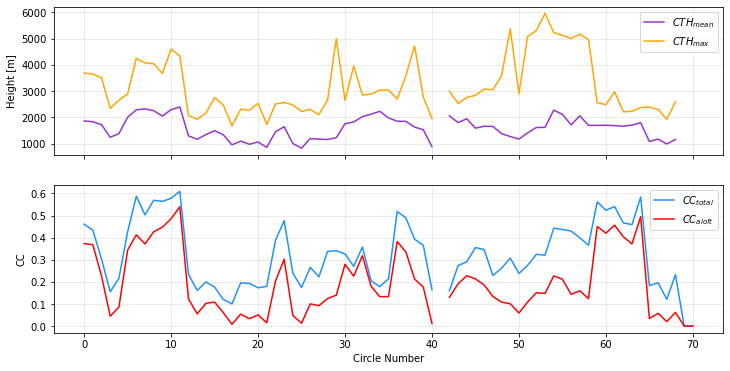

In [89]:
fig, ax = plt.subplots(2,1,figsize=(12,6), sharex=True)

ax[0].plot(cth_mean_all, c='darkorchid', label=r'$CTH_{mean}$')
ax[0].plot(cth_max_all, c='orange', label=r'$CTH_{max}$')
ax[0].grid(alpha=0.3)
ax[0].set_ylabel('Height [m]')
ax[0].legend()

'''
ax[1].plot(cf_min_total_all, c='dodgerblue', label=r'$CC_{total}^{min}$')
#ax[1].plot(cf_min_aloft_all, c='red', label=r'$CC_{aloft}^{min}$')
ax[1].grid(alpha=0.3)
ax[1].set_ylabel('Height [m]')
ax[1].legend()
'''

ax[1].plot(cf_total_all, c='dodgerblue', label=r'$CC_{total}$')
ax[1].plot(cf_aloft_all, c='red', label=r'$CC_{aloft}$')
ax[1].grid(alpha=0.3)
ax[1].set_ylabel('CC')
ax[1].legend(loc='upper right')

ax[1].set_xlabel('Circle Number')
plt.savefig('cc_cth_timeseries.png', dpi=300, bbox_inches='tight')

# Cloud-controlling factor analysis

## Magnitude and Variability
What is the mean and standard deviation of the different CCF and cloud products? How do they compare with longer-term statistics (as e.g. shown in this paper)?

In [93]:
# Find mean and standard deviations

all_mean_cloud_vars = np.full(len(cloud_vars), np.nan)
all_std_cloud_vars = np.full(len(cloud_vars), np.nan)
all_mean_ccf = np.full(len(ccf), np.nan)
all_std_ccf = np.full(len(ccf), np.nan)

print('Cloud Variables:')
print('----------------')

for i, var in enumerate(cloud_vars):
    
    mean_var = np.nanmean(var)
    std_var = np.nanstd(var)
    
    all_mean_cloud_vars[i] = mean_var
    all_std_cloud_vars[i] = std_var
    
    display(Markdown(r'{} = {} $\pm$ {}'.format(cloud_vars_names[i], round(mean_var,5), round(std_var,5))))
    
print()
print('Cloud Controlling Factors:')
print('--------------------------')

for j, f in enumerate(ccf):
    
    mean_f = np.nanmean(f)
    std_f = np.nanstd(f)
    
    all_mean_ccf[j] = mean_f
    all_std_ccf[j] = std_f
    
    display(Markdown(r'{} = {} $\pm$ {}'.format(ccf_names[j], round(mean_f,5), round(std_f,5))))
    

Cloud Variables:
----------------


$CC_{total}$ = 0.31985 $\pm$ 0.14893

$CC_{aloft}$ = 0.19344 $\pm$ 0.14688

$CTH_{mean}$ [m] = 1596.58245 $\pm$ 414.67346

$CTH_{max}$ [m] = 3187.12862 $\pm$ 1075.40148


Cloud Controlling Factors:
--------------------------


$U_{surf}$ = 7.99053 $\pm$ 2.22424

$U_{shear}$ = -3.47464 $\pm$ 2.73064

$W_{1km}$ = -0.00128 $\pm$ 0.0083

$W_{3km}$ = -0.0035 $\pm$ 0.00928

$W_{5km}$ = -0.00501 $\pm$ 0.01566

$q_{700hPa}$ = 0.00209 $\pm$ 0.00187

$IWV$ = 32.32195 $\pm$ 4.0161

$\theta_{700hPa} - \theta_{1000hPa}$ = 15.01117 $\pm$ 1.3295

$T_{adv}^{zonal}$ = -1e-05 $\pm$ 2e-05

- The magnitude and variability calculated here are on the circle scale, so for a time scale of less than one day. There is very large variability, as expected for such a short timescale, especially for the vertical velocities and zonal temperature advection (te standard deviation is even larger than the magnitude). The variability is the least for the integrated water vapor (perhaps because it is an integrated quantity and is independent of the water vapor distribution, which might be more variable), upper tropospheric stability, and surface wind (although this is more variable than the last two. In terms of the cloud variables, we find them all to be very variable. It would be interesting to check if the most variable CCF are the ones which exhibit the strongest correlation with the cloud variables, or if the CC/CTH variability is muted by a stronger correlation of these quantities with the less variable CCF. In addition, here we are considering Winter conditions, so we cannot comment on the seasonal variability (Summer vs. Winter), as in the Brueck et al. (2015) paper. There, they find that the cloud cover at low levels exhibits a small seasonality, and while we didn't look at it here, it might be the same for CC aloft and total CC. They find that CC maintains a robust mean low CC throughout the seasons, even if they experience very different meteorologies. This might suggest that there are CCF with nearly equally strong, opposite correlations with the CC.

## CCF correlation
Make scatterplots of all the cloud variables vs. the CCF and add the correlation coefficient of the
relationships as a legend. Discuss what the most important factors controlling total cloud cover, CCaloft,
and cloud top height are for the EUREC4A data. Are they consistent with the literature?

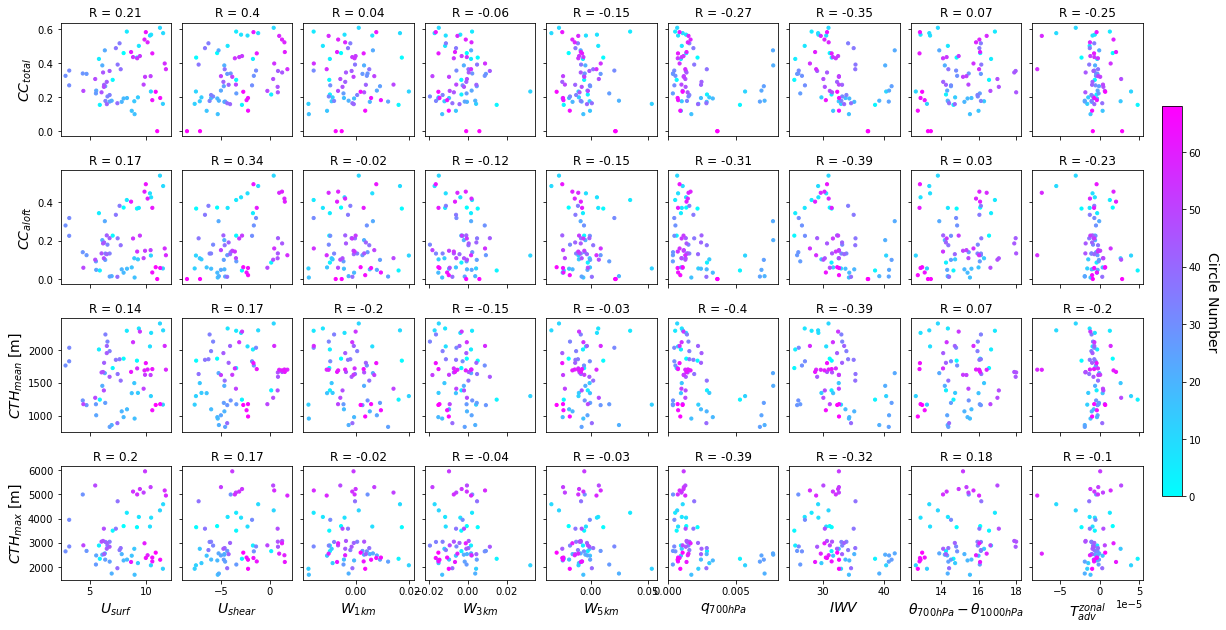

In [94]:
fig, ax = plt.subplots(4,9, figsize=(20,9), sharey='row', sharex='col')
plt.subplots_adjust(top=0.92, bottom=0.06, left=0.05, right=0.95, hspace=0.3, wspace=0.1)
fs = 14
plt.title('One-circle Averaging', fontsize=fs+2)

for i, var in enumerate(cloud_vars):
    
    for j, f in enumerate(ccf):
                
        # Compute the correlation ignoring NaNs        
        mask = ~np.isnan(var) & ~np.isnan(f)
        corr_coeff = np.corrcoef(var[mask], f[mask])[0, 1]
        
        # Make the scatter plot for each correlation
        sc = ax[i,j].scatter(f, var, s=10, c=np.arange(len(var)), cmap='cool')

        # Annotate the correlation coefficient
        ax[i,j].set_title('R = ' + str(round(corr_coeff, 2)))#, position=(0.15,0.5))
        
        ax[3,j].set_xlabel(ccf_names[j], fontsize=fs)
        ax[i,0].set_ylabel(cloud_vars_names[i], fontsize=fs)
        
cbar = fig.colorbar(sc, ax=ax.ravel().tolist(), shrink=0.7, pad=0.015)
cbar.set_label('Circle Number', fontsize=fs, rotation=270, labelpad=18)

#plt.savefig('ccf_correlations.png', dpi=300, bbox_inches='tight')

At the circle scale, we find the strongest correlations between:
    - total and aloft CC with: surface wind, wind shear, moisture content at 700hPa, integrated water vapor, and zonal temperature advection.
    - CTH with: vertical velocities at 1 and 3 km, moisture at 700hPa, integrated water vapor, and temperature advection.
    
In Brueck et al. (2015) they find that low CC is most strongly correlated with surface wind speed, temperature advection, and wind direction. This is mostly consistent with what we find here, except they see a small correlation with the wind shear (our wind shear is the difference in wind magnitude, with directional sign). They see small correlations of CC with vertical velocity, RH, lower tropospheric stability. We find similar results. They suggest this might be because larger vertical velocity leads to stronger inversion strength, but lower RH, thus having opposing effects on CC. 

The correlations in their work are much larger, but they consider a much longer timescale (12 years), whereas we only look at one month.

## Three-circle scale 
Instead of looking at each circle, look at  longer time scale by averaging over 3 circles.

In [14]:
def three_circ_avg(circle_val_array):
    circle_val_array = np.array(xr.DataArray(circle_val_array,dims='circle').rolling(circle=3, min_periods=1).mean())[0::3]
    return circle_val_array

# Save mean values for each cloud variable for each set of 3 circles
cf_min_total_all3 = three_circ_avg(cf_min_total_all)
cf_min_aloft_all3 = three_circ_avg(cf_min_aloft_all)
cf_max_total_all3 = three_circ_avg(cf_max_total_all)
cf_max_aloft_all3 = three_circ_avg(cf_max_aloft_all)
cth_mean_all3     = three_circ_avg(cth_mean_all)
cth_max_all3      = three_circ_avg(cth_max_all)
cf_min_total_all3 = three_circ_avg(cf_min_total_all)

# Save mean values for each cloud controlling factor for each set of 3 circles
wind_surf_all3  = three_circ_avg(wind_surf_all)
wind_shear_all3 = three_circ_avg(wind_shear_all)
W_1km_all3      = three_circ_avg(W_1km_all)
W_3km_all3      = three_circ_avg(W_3km_all)
W_5km_all3      = three_circ_avg(W_5km_all)
q_700hPa_all3   = three_circ_avg(q_700hPa_all)
IWV_all3        = three_circ_avg(IWV_all)
low_trop_s_all3 = three_circ_avg(low_trop_s_all)
temp_adv_all3   = three_circ_avg(temp_adv_all)

In [15]:
# Make 2D arrays from all the CCF and cloud variables
ccf_3 = np.array([wind_surf_all3, wind_shear_all3, W_1km_all3, W_3km_all3, W_5km_all3, q_700hPa_all3, IWV_all3, 
            low_trop_s_all3, temp_adv_all3])
cloud_vars_3 = np.array([cf_max_total_all3, cf_max_aloft_all3, cth_mean_all3, cth_max_all3])

Get mean values and standard deviation

In [16]:
# Find mean and standard deviations

all_mean_cloud_vars_3 = np.full(len(cloud_vars_3), np.nan)
all_std_cloud_vars_3 = np.full(len(cloud_vars_3), np.nan)
all_mean_ccf_3 = np.full(len(ccf_3), np.nan)
all_std_ccf_3 = np.full(len(ccf_3), np.nan)

print('Cloud Variables:')
print('----------------')

for i, var in enumerate(cloud_vars_3):
    
    mean_var = np.nanmean(var)
    std_var = np.nanstd(var)
    
    all_mean_cloud_vars_3[i] = mean_var
    all_std_cloud_vars_3[i] = std_var
    
    display(Markdown(r'{} = {} $\pm$ {}'.format(cloud_vars_names[i], round(mean_var,5), round(std_var,5))))
    
print()
print('Cloud Controlling Factors:')
print('--------------------------')

for j, f in enumerate(ccf_3):
    
    mean_f = np.nanmean(f)
    std_f = np.nanstd(f)
    
    all_mean_ccf_3[j] = mean_f
    all_std_ccf_3[j] = std_f
    
    display(Markdown(r'{} = {} $\pm$ {}'.format(ccf_names[j], round(mean_f,5), round(std_f,5))))
    

Cloud Variables:
----------------


$CC_{total}$ = 0.33732 $\pm$ 0.11611

$CC_{aloft}$ = 0.20443 $\pm$ 0.11842

$CTH_{mean}$ [m] = 1595.22924 $\pm$ 340.67262

$CTH_{max}$ [m] = 3178.49406 $\pm$ 891.82393


Cloud Controlling Factors:
--------------------------


$U_{surf}$ = 8.03674 $\pm$ 2.04017

$U_{shear}$ = -3.4281 $\pm$ 2.25591

$W_{1km}$ = -0.00135 $\pm$ 0.00646

$W_{3km}$ = -0.00388 $\pm$ 0.00575

$W_{5km}$ = -0.00631 $\pm$ 0.00887

$q_{700hPa}$ = 0.00203 $\pm$ 0.00152

$IWV$ = 3.21542 $\pm$ 0.30584

$\theta_{700hPa} - \theta_{1000hPa}$ = 15.08616 $\pm$ 1.08348

$T_{adv}^{zonal}$ = -0.0 $\pm$ 1e-05

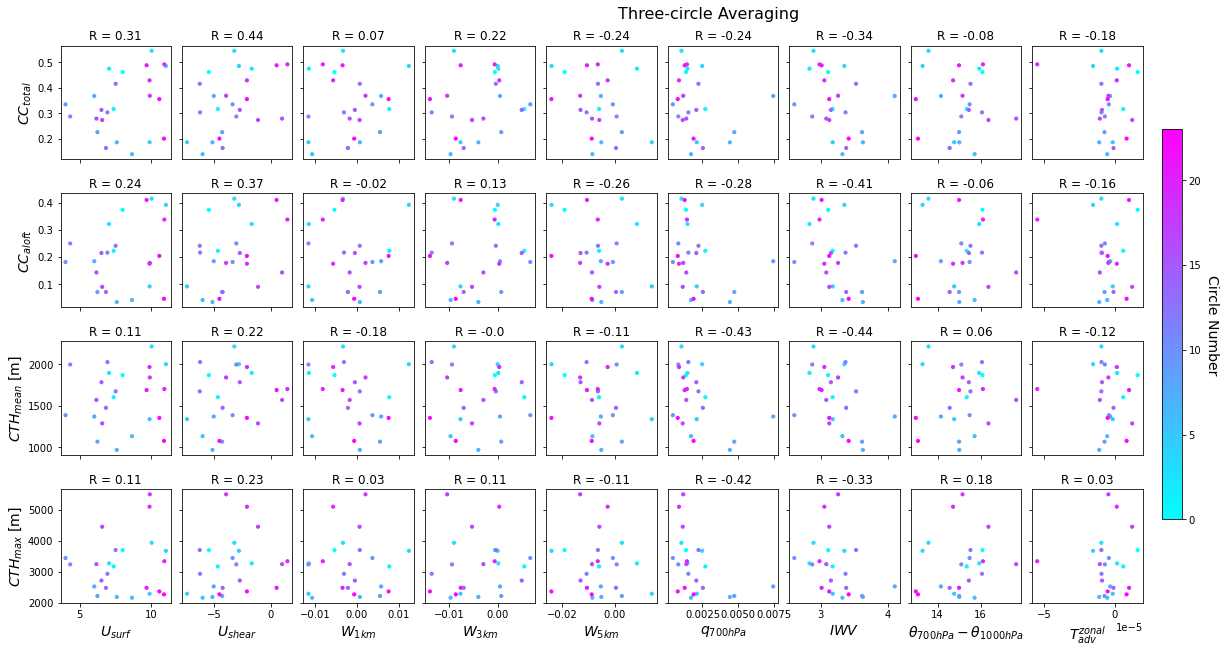

In [17]:
fig, ax = plt.subplots(4,9, figsize=(20,9), sharey='row', sharex='col')
plt.subplots_adjust(top=0.92, bottom=0.06, left=0.05, right=0.95, hspace=0.3, wspace=0.1)
plt.suptitle('Three-circle Averaging', fontsize=fs+2)

for i, var in enumerate(cloud_vars_3):
    
    for j, f in enumerate(ccf_3):
                
        # Compute the correlation ignoring NaNs        
        mask = ~np.isnan(var) & ~np.isnan(f)
        corr_coeff = np.corrcoef(var[mask], f[mask])[0, 1]
        
        # Make the scatter plot for each correlation
        sc = ax[i,j].scatter(f, var, s=10, c=np.arange(len(var)), cmap='cool')
        
        # Annotate the correlation coefficient
        ax[i,j].set_title('R = ' + str(round(corr_coeff[1][0], 2)))#, position=(0.15,0.5))
        
        ax[3,j].set_xlabel(ccf_names[j], fontsize=fs)
        ax[i,0].set_ylabel(cloud_vars_names[i], fontsize=fs)

cbar = fig.colorbar(sc, ax=ax.ravel().tolist(), shrink=0.7, pad=0.015)
cbar.set_label('Circle Number', fontsize=fs, rotation=270, labelpad=18)

plt.savefig('ccf_correlations_3circles.png', dpi=300, bbox_inches='tight')

Correlations become slightly larger when considering the longer scale of three circles, but they are still not as large as the 12 years found in the paper. We are still only considering one month.

# Introduction to Wikipedia article: Cold Pools

In atmospheric science, a cold pool (CP) is a density-driven downdraft of unsaturated air cooled by evaporation of precipitation. Evaporation of precipitation cools the air, which becomes denser than the environmental air and sinks towards the surface. This downdraft of denser air spreads radially outward. The expansion of the cold density currents may lead to the mechanical lifting of adjacent air and contribute to the organization of convection and clouds (Zuidema et al., 2017). From satellite images, cold pools can be identified as mesoscale arcs of clouds surrounding clear-sky areas or stratiform decks (Vogel et al., 2021). 

Cold pools span 10-200 km in diameter, and spread at about 10 m/s. They end when their features can no longer be distinguished from the large-flow. Nearly all clouds that produce precipitation rates larger than 1 mm/h are associated with cold pools in the trade wind region (Zuidema et al., 2012), and cold pools are ubiquitous both over land and ocean (Kirsch et al., 2022).

The characteristics and impact of cold pools vary depending on the properties of the parent convection, such as degree of organization and depth (deep or shallow convection), and the large-scale environment in which they originate (Zuidema et al., 2017).

Common detection methods rely on measurements of strong and abrupt surface temperature drops (Vogel et al., 2021) or the onset of strong rain rates (Young et al., 1995), but they can also be identified from changes in depth of the atmospheric mixed layer (Touze-Peiffer et al., 2021). 

Cold pools have also been studied using Large Eddy Simulations (LES) and cloud resolving models (CRM) over smaller domains, where they span 6 to 36 km in diameter and last 2.5 h (Tompkins et al., 2001).

### Feedback

- first paragraph: keep 1st sentence and add expansion
- less detail in the impacts
- 3: instead of degree of org, rain rate
- condense last 2 par. with last sentence of first.
- thunderstorm clouds to shallow cumulus